## Dependencies

In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt

import numpy as np

import torch.nn.functional as F
from torch.utils.data import DataLoader
from time import time

In [5]:
from torchvision import transforms

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# Load base dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

###########################################
# WHAT DATASET TO USE
#
# Possible Values:
# - 'permuted_mnist'
# - 'rotated_mnist'
###########################################
DATASET_USED = 'permuted_mnist'

#if DATASET_USED == 'permuted_mnist':
#
#    # Permute the dataset
#    permutation = torch.randperm(28 * 28)
#    raw_dataset.data = raw_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
#    test_dataset.data = test_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
#
#elif DATASET_USED == 'rotated_mnist':
#
#    # TODO rotate data
#
#    raise Exception("not implemented yet")
#else:
#    raise Exception("Invalid dataset")

# Precompute batches for test dataset to spare some time during training
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Using device: cuda


## Util Functions

### Evaluation

In [6]:
def evaluate_accuracy(model):
    """
    Evaluate test accuracy of the given model on the test split
    """
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

### Training Functions

In [19]:
def train_epoch(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_function,
    device: torch.device,
):
    """
    Training function. Loads the batch, perform forward pass, compute gradients and perform backward pass.
    Only difference is that you can pass the loss function as an argument.
    This allows to use a simple cross entropy loss function, or a more complex one including L2 or EWC regularization.
    """

    train_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = loss_function(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    return train_loss / len(train_dataloader)

def validate_epoch(
    model: torch.nn.Module,
    val_dataloader: DataLoader,
    loss_function,
    device: torch.device,
):
    """
    Validates the model on the validation split.
    """

    val_loss = 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # do the forward pass
            output = model(data)

            # compute the loss
            loss = loss_function(output, target)

            # print statistics
            val_loss += loss.item()

    return val_loss / len(val_dataloader)

def fit(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    loss_function,
    epochs: int,
    device: torch.device,
):
    """
    The fit method calls the train_epoch() method for a specified
    number of epochs and returns the train and validation losses.
    """

    # keep track of the losses in order to visualize them later
    train_losses = []
    val_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        
        t = time() # current time

        # train function
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            loss_function=loss_function,
            optimizer=optimizer,
            device=device,
        )

        # validate model
        val_loss = validate_epoch(
            model=model,
            val_dataloader=val_dataloader,
            loss_function=loss_function,
            device=device
        )

        # compute test accuracy
        test_accuracy = evaluate_accuracy(model)
        
        # step scheduler if needed
        if scheduler != None:
            scheduler.step()
        
        # append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_accuracies.append(test_accuracy)

        dt = time() - t # time difference
        print(f"Epoch [{epoch + 1}/{epochs}]: train={round(train_loss, 4)} val={round(val_loss, 4)} test={round(test_accuracy * 100, 1)} ({round(dt, 1)}s)")

    return train_losses, val_losses, test_accuracies


## Model architecture

In [16]:
class SmallNet(torch.nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()

        self._input_size = 28 * 28
        self._n_ff       = 100
        self._n_output   = 10
        self._do_input   = 0.2
        self._do_ff      = 0.5
        
        self.do0 = torch.nn.Dropout(self._do_input)

        self.ff1 = torch.nn.Linear(self._input_size, self._n_ff)
        self.do1 = torch.nn.Dropout(self._do_ff)

        self.ff2 = torch.nn.Linear(self._n_ff, self._n_ff)
        self.do2 = torch.nn.Dropout(self._do_ff)

        #self.ff3 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do3 = torch.nn.Dropout(self._do_ff)

        #self.ff4 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do4 = torch.nn.Dropout(self._do_ff)

        #self.ff5 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do5 = torch.nn.Dropout(self._do_ff)

        #self.ff6 = torch.nn.Linear(self._n_ff, self._n_ff)
        #self.do6 = torch.nn.Dropout(self._do_ff)

        self.ff7 = torch.nn.Linear(self._n_ff, self._n_output)

    def forward(self, x):

        # input dropout of 50% as stated in paper
        x = self.do0(x)

        # dense FF hidden layers, each with 20% dropout and ReLU activation
        # dropout is generally placed after the activation
        x = self.do1(F.relu(self.ff1(x)))
        x = self.do2(F.relu(self.ff2(x)))
        #x = self.do3(F.relu(self.ff3(x)))
        #x = self.do4(F.relu(self.ff4(x)))
        #x = self.do5(F.relu(self.ff5(x)))
        #x = self.do6(F.relu(self.ff6(x)))

        # classification layer
        x = self.ff7(x)

        return x

print("Model Parameters: ", sum(p.numel() for p in SmallNet().parameters()))

Model Parameters:  89610


### Training the model

Training Samples  : 54000
Validation Samples: 6000
Training model...
Epoch [1/10]: train=2.2602 val=2.1612 test=45.9 (4.0s)
Epoch [2/10]: train=1.9792 val=1.5463 test=67.8 (4.0s)
Epoch [3/10]: train=1.4474 val=0.9753 test=78.0 (4.0s)
Epoch [4/10]: train=1.1253 val=0.734 test=82.1 (4.1s)
Epoch [5/10]: train=0.9539 val=0.6017 test=85.6 (3.4s)
Epoch [6/10]: train=0.8463 val=0.5229 test=87.2 (3.6s)
Epoch [7/10]: train=0.7696 val=0.4715 test=88.2 (4.1s)
Epoch [8/10]: train=0.7139 val=0.4335 test=88.9 (3.3s)
Epoch [9/10]: train=0.6705 val=0.4042 test=89.5 (3.3s)
Epoch [10/10]: train=0.6361 val=0.379 test=90.3 (3.7s)
Plotting curves...


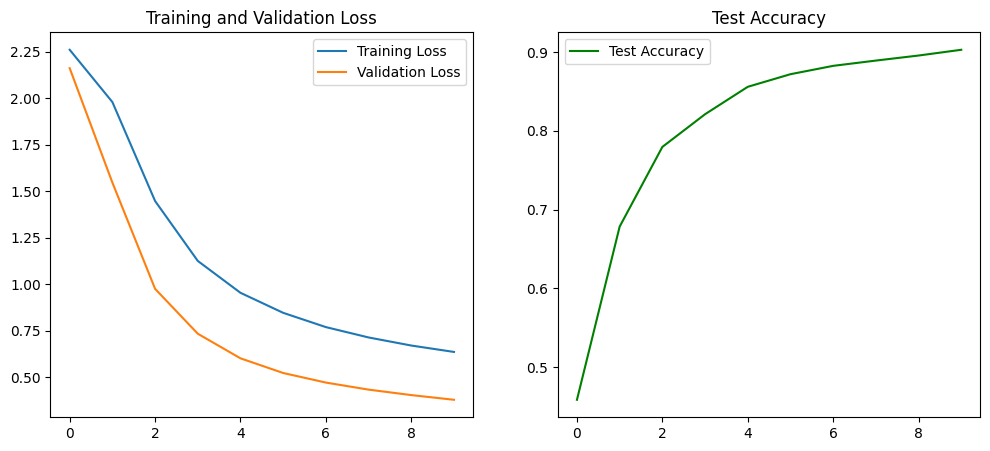

Done!


In [21]:
# Initialize model
model = SmallNet()
model.to(device)

# Loss, optimizer and scheduler
N_EPOCHS = 10
FILE_NAME = "smallnet_base"

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

# split train and validation sets
val_size = int(0.1 * len(raw_dataset))
train_size = len(raw_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [train_size, val_size])

# create new dataloaders for training and validation sets
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Training Samples  : {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')

print('Training model...')
train_losses, val_losses, test_accuracies = fit(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_function=F.cross_entropy,
    scheduler=None,
    epochs=N_EPOCHS,
    device=device,
)

# Save model and curves
torch.save(model.state_dict(), f'{FILE_NAME}.pt')
np.save(f'{FILE_NAME}_train_losses.npy', train_losses)
np.save(f'{FILE_NAME}_val_losses.npy', val_losses)

# Plot loss as fct of epoch
print('Plotting curves...')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')

# Plot test accuracy
axs[1].plot(test_accuracies, label='Test Accuracy', color='green')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.show()

print('Done!');